In [1]:
import pandas as pd
import numpy as np

# --- Load datasets ---
funding = pd.read_csv("D:\\Homework\\QF634\\project\\TAOUSDT_funding_rate_20200101_20251130.csv", parse_dates=["fundingDateTime"], date_parser=lambda x: pd.to_datetime(x, format="%Y-%m-%d %H:%M:%S.%f"))
funding = funding.sort_values("fundingDateTime").drop("formattedFundingDateTime",axis = 1).drop("symbol",axis = 1)
funding.rename(columns={'fundingDateTime': 'timestamp'}, inplace=True)

spot = pd.read_json('D:\\Homework\\QF634\\project\\Data\\raw_historical_price\\TAOUSDT_5m_binance_spot_historical_data.json',lines=True)           # columns: timestamp, open, high, low, close, volume, quote_asset_volume, number_of_trades, taker_buy_base_asset_volume, taker_buy_quote_asset_volume
future = pd.read_json('D:\\Homework\\QF634\\project\\Data\\raw_historical_price\\TAOUSDT_5m_binance_futures_historical_data.json',lines=True) 

# --- Convert timestamp to datetime and set index ---
for df in [funding, spot, future]:
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df['timestamp'] = df['timestamp'].dt.round('S')

funding.set_index('timestamp', inplace=True)
spot.set_index('timestamp', inplace=True)
future.set_index('timestamp', inplace=True)

print(funding.head)
print(spot.head)
print(future.head)

C:\Users\timkf\AppData\Local\Temp\ipykernel_17800\1885567346.py:5: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  funding = pd.read_csv("D:\\Homework\\QF634\\project\\TAOUSDT_funding_rate_20200101_20251130.csv", parse_dates=["fundingDateTime"], date_parser=lambda x: pd.to_datetime(x, format="%Y-%m-%d %H:%M:%S.%f"))


<bound method NDFrame.head of                      fundingRate   markPrice
timestamp                                   
2024-04-11 16:00:00     0.000050  647.610775
2024-04-11 20:00:00     0.000050  637.064082
2024-04-12 00:00:00     0.000050  623.858602
2024-04-12 04:00:00     0.000044  613.390000
2024-04-12 08:00:00    -0.000882  637.859742
...                          ...         ...
2025-11-29 08:00:00     0.000042  298.560000
2025-11-29 12:00:00     0.000050  299.080000
2025-11-29 16:00:00     0.000035  297.060000
2025-11-29 20:00:00     0.000042  294.620000
2025-11-30 00:00:00    -0.000002  296.180000

[3585 rows x 2 columns]>
<bound method NDFrame.head of                       open    high    low  close      volume  \
timestamp                                                      
2024-04-11 12:00:00  439.8  1249.0  439.8  879.6  38286.3042   
2024-04-11 12:05:00  879.6   890.0  710.0  724.2  22655.2730   
2024-04-11 12:10:00  723.0   740.0  702.0  733.2  10616.3921   
2024-04-1

C:\Users\timkf\AppData\Local\Temp\ipykernel_17800\1885567346.py:15: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  df['timestamp'] = df['timestamp'].dt.round('S')
C:\Users\timkf\AppData\Local\Temp\ipykernel_17800\1885567346.py:15: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  df['timestamp'] = df['timestamp'].dt.round('S')
C:\Users\timkf\AppData\Local\Temp\ipykernel_17800\1885567346.py:15: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  df['timestamp'] = df['timestamp'].dt.round('S')


In [29]:
def rolling_features(df, prefix, window='1H'):
    df_feat = df.copy()
    
    # 1. Returns
    df_feat['return'] = df_feat['close'].pct_change()
    
    # 2. Rolling volatility
    df_feat[f'{prefix}_volatility_roll'] = df_feat['return'].rolling(window=window).std()
    
    # 3. Momentum (price change over window)
    df_feat[f'{prefix}_momentum'] = df_feat['close'].pct_change(periods=int(pd.Timedelta(window)/pd.Timedelta('5min')))
    
    # 4. Max drawdown in rolling window
    roll_max = df_feat['close'].rolling(window=window).max()
    df_feat[f'{prefix}_max_drawdown'] = (df_feat['close'] - roll_max) / roll_max
    
    return df_feat

# --- Add rolling features (1-hour rolling example) ---
spot = rolling_features(spot, 'spot', window='1h')
future = rolling_features(future, 'future', window='1h')

# --- Resample 5-min data to 8h aggregates ---
def resample_5min_to_8h(df, prefix):
    agg_dict = {
        'open': 'first',
        'high': 'max',
        'low': 'min',
        'close': 'last',
        'volume': 'sum',
        'quote_asset_volume': 'sum',
        'number_of_trades': 'sum',
        'taker_buy_base_asset_volume': 'sum',
        'taker_buy_quote_asset_volume': 'sum',
        f'return': 'mean',
        f'{prefix}_volatility_roll': 'mean',
        f'{prefix}_momentum': 'mean',
        f'{prefix}_max_drawdown': 'min'
    }
    df_4h = df.resample('4h').agg(agg_dict)
    
    # Taker ratio
    df_4h[f'{prefix}_taker_ratio'] = df_4h['taker_buy_base_asset_volume'] / (df_4h['volume'] + 1e-9)
    
    # Rename columns with prefix
    df_4h = df_4h.add_prefix(f'{prefix}_')
    
    return df_4h

spot_4h = resample_5min_to_8h(spot, 'spot')
future_4h = resample_5min_to_8h(future, 'future')

print(spot_4h.head)
print(future_4h.head)

<bound method NDFrame.head of                      spot_open  spot_high  spot_low  spot_close  spot_volume  \
timestamp                                                                      
2024-04-11 12:00:00      439.8     1249.0     439.8       648.2  180376.5376   
2024-04-11 16:00:00      647.7      658.0     617.3       637.9   32325.7883   
2024-04-11 20:00:00      637.9      671.6     621.1       623.4   28376.8491   
2024-04-12 00:00:00      623.6      640.9     602.1       614.0   16929.9042   
2024-04-12 04:00:00      614.1      646.3     596.5       638.0   22186.6199   
...                        ...        ...       ...         ...          ...   
2025-11-30 00:00:00      296.4      297.4     290.2       295.0    6213.3370   
2025-11-30 04:00:00      295.1      296.4     292.9       294.1    6360.3467   
2025-11-30 08:00:00      294.2      296.1     291.5       292.1    6870.9802   
2025-11-30 12:00:00      292.1      296.7     290.8       293.3    9942.8080   
2025-11-30

In [30]:
# --- Helper functions for rolling features ---

# --- Merge features with funding rate ---
df_final = funding.merge(spot_4h, left_index=True, right_index=True, how='left').merge(future_4h, left_index=True, right_index=True, how='left')

print(df_final.head)



<bound method NDFrame.head of                      fundingRate   markPrice  spot_open  spot_high  spot_low  \
timestamp                                                                      
2024-04-11 16:00:00     0.000050  647.610775      647.7      658.0     617.3   
2024-04-11 20:00:00     0.000050  637.064082      637.9      671.6     621.1   
2024-04-12 00:00:00     0.000050  623.858602      623.6      640.9     602.1   
2024-04-12 04:00:00     0.000044  613.390000      614.1      646.3     596.5   
2024-04-12 08:00:00    -0.000882  637.859742      638.4      645.8     611.9   
...                          ...         ...        ...        ...       ...   
2025-11-29 08:00:00     0.000042  298.560000      298.6      299.7     295.7   
2025-11-29 12:00:00     0.000050  299.080000      299.2      299.5     294.1   
2025-11-29 16:00:00     0.000035  297.060000      297.2      297.2     292.2   
2025-11-29 20:00:00     0.000042  294.620000      294.8      297.3     294.4   
2025-11-30

In [31]:
# --- Lag features (past 1-3 intervals) ---
# lags = [1, 2, 3, 4, 6, 12]
# for lag in lags:
#     df_final[f'funding_rate_lag_{lag}'] = df_final['fundingRate'].shift(lag)
#     for col in df_final.columns:
#         if 'spot_' in col or 'future_' in col:
#             df_final[f'{col}_lag_{lag}'] = df_final[col].shift(lag)

# --- Drop NaNs from lagging ---
df_final_lagged = df_final.dropna()
df_final_lagged.reset_index(inplace=True)

print("Feature dataset with rolling features ready for ML:")
print(df_final_lagged.head)

Feature dataset with rolling features ready for ML:
<bound method NDFrame.head of                timestamp  fundingRate   markPrice  spot_open  spot_high  \
0    2024-04-11 16:00:00     0.000050  647.610775      647.7      658.0   
1    2024-04-11 20:00:00     0.000050  637.064082      637.9      671.6   
2    2024-04-12 00:00:00     0.000050  623.858602      623.6      640.9   
3    2024-04-12 04:00:00     0.000044  613.390000      614.1      646.3   
4    2024-04-12 08:00:00    -0.000882  637.859742      638.4      645.8   
...                  ...          ...         ...        ...        ...   
3580 2025-11-29 08:00:00     0.000042  298.560000      298.6      299.7   
3581 2025-11-29 12:00:00     0.000050  299.080000      299.2      299.5   
3582 2025-11-29 16:00:00     0.000035  297.060000      297.2      297.2   
3583 2025-11-29 20:00:00     0.000042  294.620000      294.8      297.3   
3584 2025-11-30 00:00:00    -0.000002  296.180000      296.4      297.4   

      spot_low  s

In [32]:
horizon_periods = 6   # 6 periods = 24 hour, 6 period
df_final_lagged["target"] = df_final_lagged["fundingRate"].rolling(horizon_periods).sum().shift(-horizon_periods)
df_final_lagged = df_final_lagged.dropna()

print(df_final_lagged.head)

<bound method NDFrame.head of                timestamp  fundingRate   markPrice  spot_open  spot_high  \
0    2024-04-11 16:00:00     0.000050  647.610775      647.7      658.0   
1    2024-04-11 20:00:00     0.000050  637.064082      637.9      671.6   
2    2024-04-12 00:00:00     0.000050  623.858602      623.6      640.9   
3    2024-04-12 04:00:00     0.000044  613.390000      614.1      646.3   
4    2024-04-12 08:00:00    -0.000882  637.859742      638.4      645.8   
...                  ...          ...         ...        ...        ...   
3574 2025-11-28 08:00:00     0.000048  301.061608      301.3      310.8   
3575 2025-11-28 12:00:00    -0.000014  303.007513      303.2      311.4   
3576 2025-11-28 16:00:00     0.000046  308.240000      308.3      309.0   
3577 2025-11-28 20:00:00    -0.000010  302.110000      302.3      303.0   
3578 2025-11-29 00:00:00    -0.000023  298.370000      298.5      300.6   

      spot_low  spot_close  spot_volume  spot_quote_asset_volume  \
0

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam

# --------------------------------------------------------
# Assume your dataframe has: timestamp, feature columns..., y
# y = cumulative funding rate for next 6 periods
# --------------------------------------------------------

df = df_final_lagged.copy()

# ======================
# 1. Feature Scaling
# ======================
features = [c for c in df.columns 
            if c not in ["timestamp", "fundingRate", "target"]]

scaler = StandardScaler()
df[features] = scaler.fit_transform(df[features])

# ======================
# 2. Create sequences
# ======================
def create_sequences(data, target, window=24):
    """
    window=48 → use the last 48 periods to predict future cumulative funding
    """
    X, y = [], []
    for i in range(len(data) - window):
        X.append(data[i:i+window])
        y.append(target[i+window])
    return np.array(X), np.array(y)

WINDOW = 24   # You can tune this

scaler_x = StandardScaler()
df[features] = scaler_x.fit_transform(df[features])

# Scale target
scaler_y = StandardScaler()
df["y_scaled"] = scaler_y.fit_transform(df[["target"]])

X, y = create_sequences(df[features].values,
                        df["y_scaled"].values,
                        WINDOW)

print("X shape:", X.shape)   # (samples, window, features)
print("y shape:", y.shape)

# ======================
# 3. Train / Test split
# ======================
split_ratio = 0.8
split = int(len(X) * split_ratio)

X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# ======================
# 4. Build RNN model
# ======================
model = Sequential([
    LSTM(64, return_sequences=False, input_shape=(WINDOW, X.shape[2])),
    Dense(32, activation="relu"),
    Dense(1)   # Regression output
])

model.compile(optimizer=Adam(1e-3), loss="mse")

model.summary()

X shape: (3555, 24, 29)
y shape: (3555,)


c:\Users\timkf\anaconda3\envs\QF634_project\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                   │ (None, 64)             │        24,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 26,177 (102.25 KB)

 Trainable params: 26,177 (102.25 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=50,
    batch_size=32,
    verbose=1
)

# ======================
# 6. Predict
# ======================
y_pred = model.predict(X_test)

print("First 10 predictions:")
print(y_pred[:10].flatten())

Epoch 1/20
89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.4130 - val_loss: 0.4907
Epoch 2/20
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.3576 - val_loss: 0.6232
Epoch 3/20
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.3270 - val_loss: 0.7566
Epoch 4/20
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.2949 - val_loss: 0.7414
Epoch 5/20
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.2761 - val_loss: 0.8640
Epoch 6/20
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.2589 - val_loss: 0.7752
Epoch 7/20
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.2480 - val_loss: 0.7859
Epoch 8/20
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.2366 - val_loss: 0.7157
Epoch 9/20
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.2151 - val_loss: 0.8527
Epoch 10/20
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.2076 - val_loss: 0.8025
Epoch 11/20
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.1949 - val_loss: 0.7117
Epoch 12/20
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.1

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


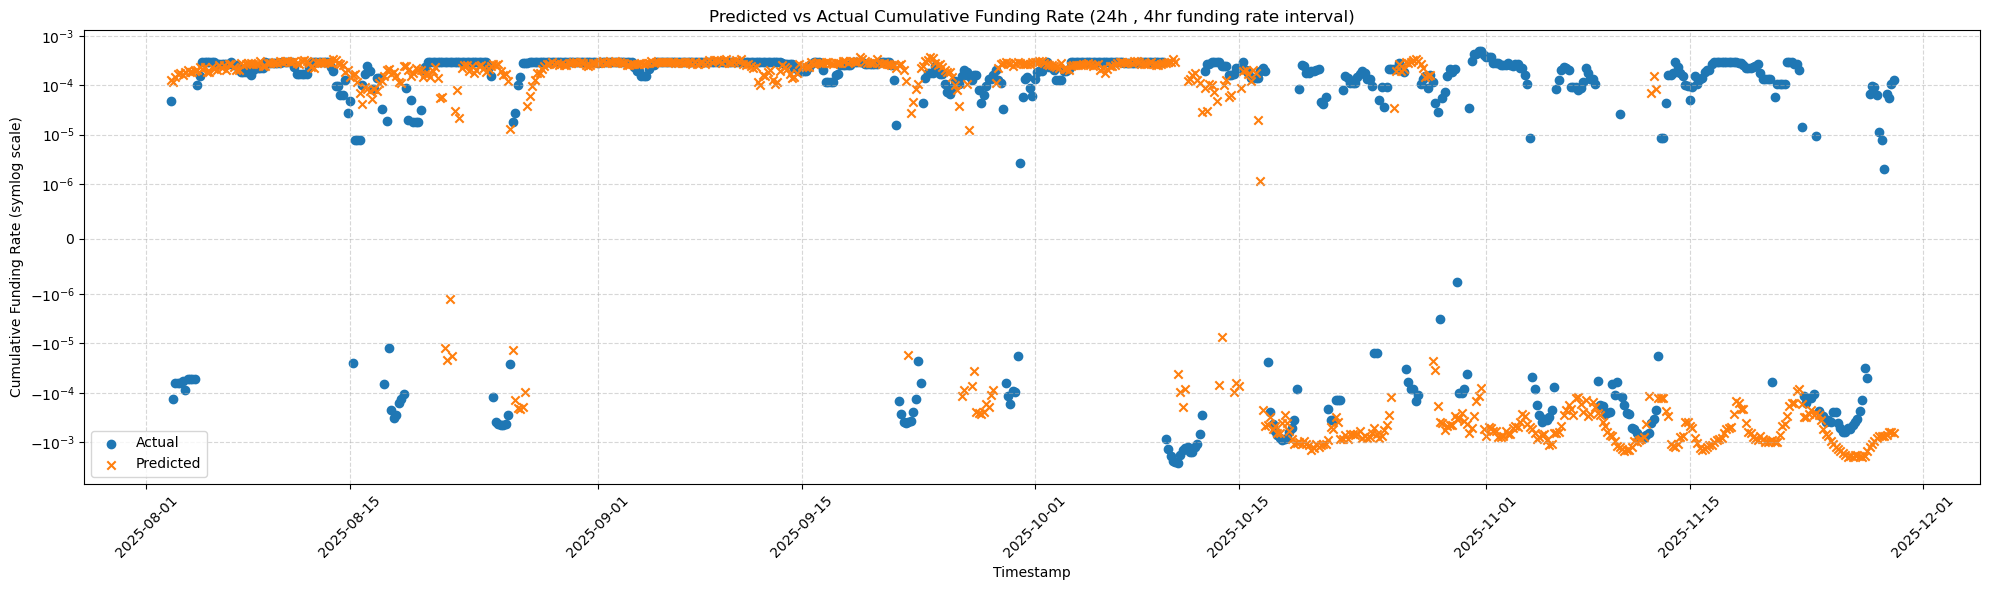

In [44]:
import matplotlib.pyplot as plt

y_pred_scaled = model.predict(X_test)
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_test = scaler_y.inverse_transform(y_test.reshape(-1, 1))
# Extract corresponding timestamps for test set
test_timestamps = df.iloc[len(df) - len(y_test):]["timestamp"]

plt.figure(figsize=(20,6))
plt.scatter(test_timestamps, y_test, label="Actual", marker='o')
plt.scatter(test_timestamps, y_pred, label="Predicted", marker='x')

# Use symmetric log scale (symlog) to handle negatives
plt.yscale("symlog", linthresh=1e-6)  # linthresh: range near zero treated as linear
plt.xlabel("Timestamp")
plt.ylabel("Cumulative Funding Rate (symlog scale)")
plt.title("Predicted vs Actual Cumulative Funding Rate (24h , 4hr funding rate interval)")
plt.legend()
plt.grid(True, which="both", linestyle="--", alpha=0.5)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()